In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob
import cv2
import imutils
import seaborn as sns
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from keras.models import Model, Sequential
import keras

In [2]:
import zipfile
import os

# Replace 'your_file.zip' with the actual name of your ZIP file
zip_file_path = 'brain_tumor_dataset.zip'
brain_tumor_dataset = 'extracted_folder'  # Specify the folder where you want to extract the contents

# Create the target directory if it doesn't exist
os.makedirs(brain_tumor_dataset, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(brain_tumor_dataset)

# Display a message indicating the successful extraction
print(f'The contents of {zip_file_path} have been successfully extracted to {brain_tumor_dataset}.')


In [4]:
# count imagees in the two folders: yes(Tumor) and no(Healthy)
root = 'brain_tumor_dataset'
dict_img = {}
for dir in os.listdir(root):
  dict_img[dir] = len(os.listdir(os.path.join(root,dir)))
dict_img

{'no': 98, 'yes': 126}

In [5]:
#Define a function for image augmentation
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest',
                                  rescale= 1/255
                                 )

    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break

In [6]:
#Create augmented images folders
#L = ['aug_train', 'aug_test', 'aug_val']
name = 'aug_data'
if not os.path.exists("./"+name):
  os.mkdir("./"+name)
  for dir in os.listdir(root):
    os.makedirs("./"+name+"/"+dir)
else:
  print(f"{name} Already exists")

aug_data Already exists


In [7]:
#Augment data for the examples with the label 'yes' in the training set
augment_data(file_dir='./brain_tumor_dataset/yes',n_generated_samples=8, save_to_dir='./aug_data/yes')
#Augment data for the examples with the label 'no' in the training set
augment_data(file_dir='./brain_tumor_dataset/no', n_generated_samples=12, save_to_dir='./aug_data/no')

In [8]:
# count images in the two folders: yes(tumor) and no(healthy) of augmented images
root = 'aug_data'
dict_img = {}
for dir in os.listdir(root):
  dict_img[dir] = len(os.listdir(os.path.join(root, dir)))
dict_img

{'no': 2543, 'yes': 2267}

In [9]:
#Define a function that creates new folders for the train, test and val sets and append random pictures to them based on the split percentage
def create_folders(name, perc):
  if not os.path.exists("./"+name):
    os.mkdir("./"+name)
    for dir in os.listdir(root):
      os.makedirs("./"+name+"/"+dir)
      for img in np.random.choice(a=os.listdir(os.path.join(root, dir)), size=(math.floor(perc*dict_img[dir])), replace=False):
        Src = os.path.join(root, dir, img)
        Dest = os.path.join("./"+name, dir)
        shutil.copy(Src, Dest)
        os.remove(Src)
  else:
    print(f'{name} Already exists')

In [10]:
# craete the training set
create_folders('train', 0.7)

In [11]:
# create the test set
create_folders('test', 0.15)

In [12]:
# create the validation set
create_folders('val', 0.15)

In [13]:
# define a function that counts images in the folders: yes (Tumor) and no (Healthy)
def count_img(folder):
  dict_img = {}
  for dir in os.listdir(folder):
    dict_img[dir] = len(os.listdir(os.path.join(folder, dir)))
  return dict_img

In [14]:
# count images in training set
count_img('train')

{'no': 1780, 'yes': 1586}

In [15]:
# count images in test set
count_img('test')

{'no': 381, 'yes': 340}

In [16]:
# count images in validation set
count_img('val')

{'no': 381, 'yes': 340}

Image Preprocessing

In [17]:
# define a function that crop the brain contour
def crop_brain_contour(image, plot=False):
  # convert the image to grayscale, and blur it slightly
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  gray = cv2.GaussianBlur(gray, (5,5), 0)

  thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
  thresh = cv2.erode(thresh, None, iterations=2)
  thresh = cv2.dilate(thresh, None, iterations=2)

  #Find contours in thresholded image, then grab the largest one
  cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  c = max(cnts, key=cv2.contourArea)

  #Extreme points
  extLeft = tuple(c[c[:, :, 0].argmin()][0])
  extRight = tuple(c[c[:, :, 0].argmax()][0])
  extTop = tuple(c[c[:, :, 1].argmin()][0])
  extBot = tuple(c[c[:, :, 1].argmax()][0])

  new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            
  if plot:
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    plt.title('Original Image')
    plt.subplot(1, 2, 2)
    plt.imshow(new_image)
    plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    plt.title('Cropped Image')
    plt.show()
  return new_image

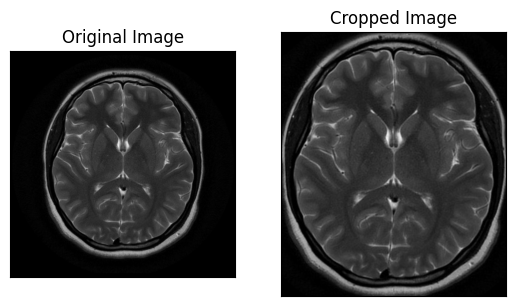

In [19]:
#Example
ex_img = cv2.imread('brain_tumor_dataset/no/1 no.jpeg')
img = crop_brain_contour(ex_img, plot=True)

In [20]:
# define a function that load data
def load_data(dir_list, image_size):
  # load all images in directory
  X = []
  y = []
  image_width, image_height = image_size
  for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
  X = np.array(X)
  y = np.array(y)
  
  # Shuffle the data
  X, y = shuffle(X, y)
  
  print(f'Number of examples is: {len(X)}')
  print(f'X shape is: {X.shape}')
  print(f'y shape is: {y.shape}')
  
  return X, y

In [22]:
# load training data
IMG_WIDTH, IMG_HEIGHT = (240, 240)
X_train, y_train = load_data(['train/yes','train/no'], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 3366
X shape is: (3366, 240, 240, 3)
y shape is: (3366, 1)


In [23]:
# define a function that plot images
def plot_sample_images(X, y, n=40):
  for label in [0,1]:
    # grab the first n images with the corresponding y values equal to label
    images = X[np.argwhere(y == label)]
    n_images = images[:n]

    columns_n = 10
    rows_n = int(n/columns_n)
    plt.figure(figsize=(10,8))
    i = 1 #current plot
    for image in n_images:
      plt.subplot(rows_n, columns_n, i);
      plt.imshow(image[0])
      plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
      i += 1
    label_to_str = lambda label: "Yes" if label == 1 else "No"
    plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
    plt.show()

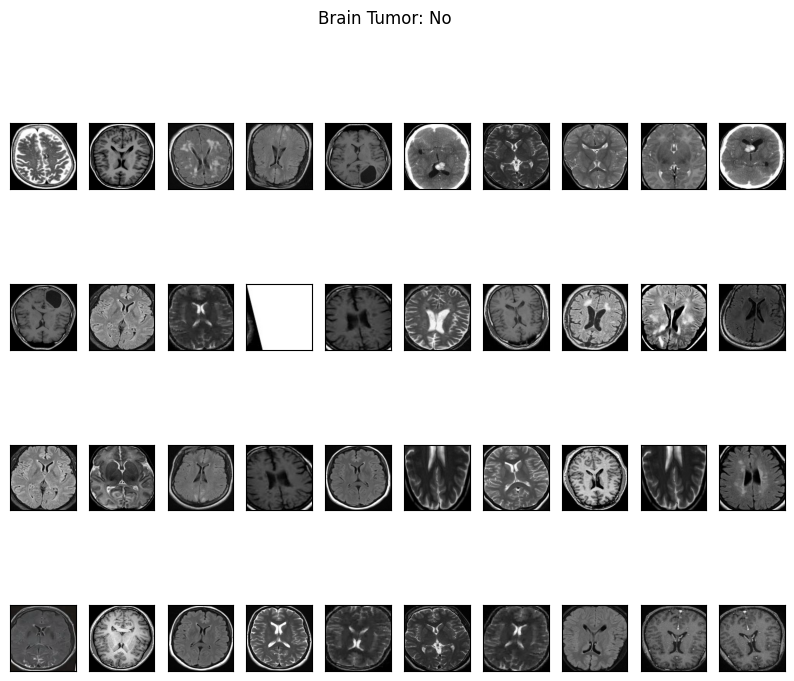

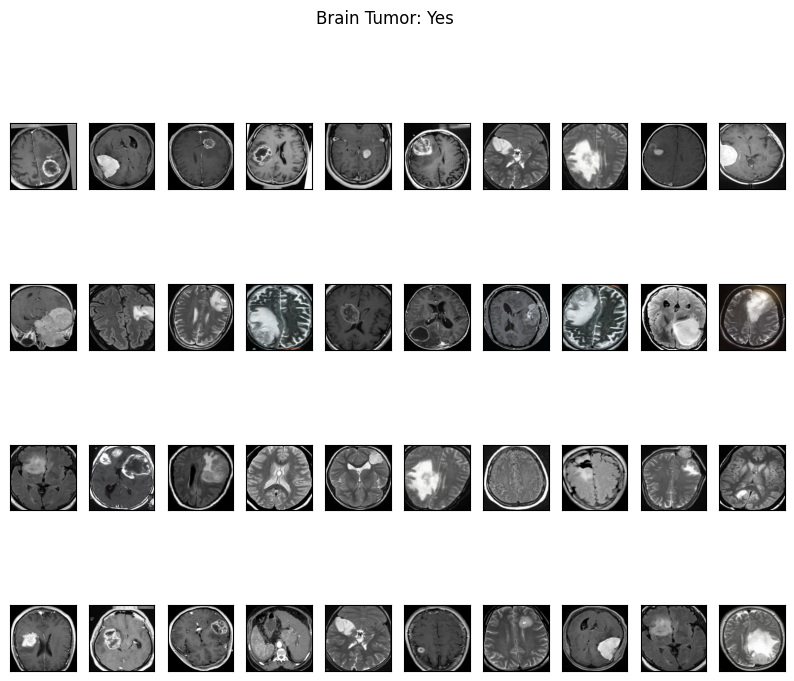

In [24]:
# plot sample from the training set
plot_sample_images(X_train, y_train)

We can notice that the noise has been deleted and some images look alike with some slight changes resulted from the data augmentation

In [25]:
#Load test data
IMG_WIDTH, IMG_HEIGHT = (240, 240)
X_test, y_test = load_data(['test/yes', 'test/no'], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 721
X shape is: (721, 240, 240, 3)
y shape is: (721, 1)


In [26]:
#Load validation data
IMG_WIDTH, IMG_HEIGHT = (240, 240)
X_val, y_val = load_data(['val/yes', 'val/no'], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 721
X shape is: (721, 240, 240, 3)
y shape is: (721, 1)


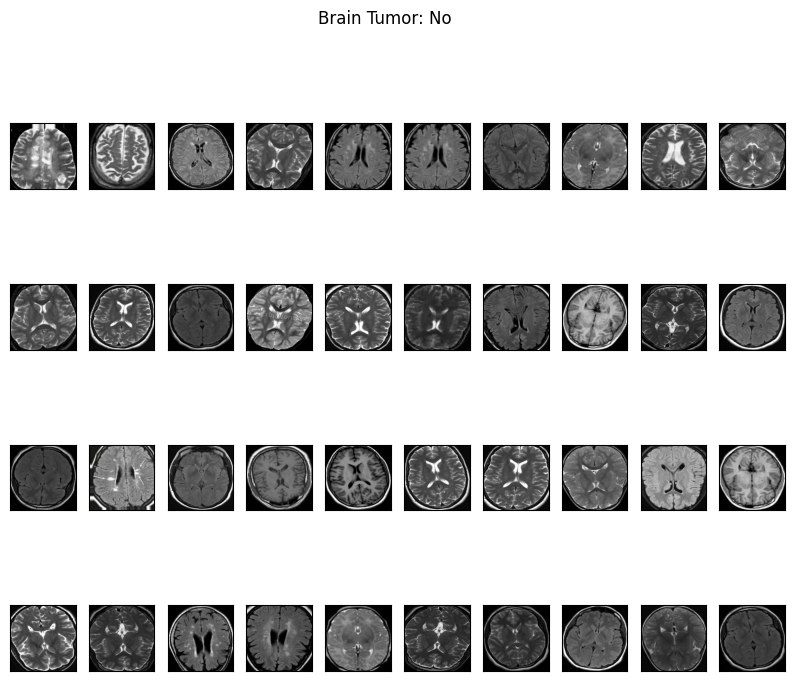

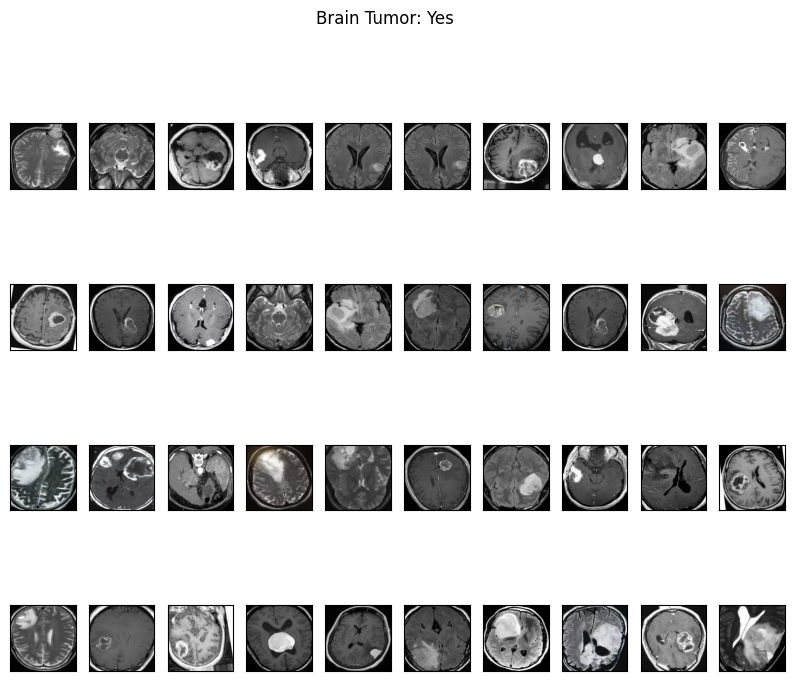

In [27]:
#Plot samples from the validation set
plot_sample_images(X_val, y_val)

CNN Model

In [28]:
#Build our model
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', input_shape = (240, 240, 3)))

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Dropout(rate = 0.25))

model.add(Flatten())
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(rate = 0.25)) 
model.add(Dense(units = 1, activation = 'sigmoid'))

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 238, 238, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 236, 236, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2  (None, 118, 118, 32)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 116, 116, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 58, 58, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 128)      

In [29]:
#Compile our model
model.compile(optimizer = 'adam', loss = keras.losses.binary_crossentropy, metrics = ['accuracy'])

In [30]:
#Early stopping and model checkpoint
from keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.01, patience = 5, verbose = 1, mode = 'auto')
mc = ModelCheckpoint(monitor ='val_accuracy', filepath = './bestmodel.h5', verbose = 1, save_best_only = True, mode = 'auto')

cd = [es, mc]

In [31]:
#Train our model
hist = model.fit(x = X_train, y = y_train, batch_size = 32, epochs = 30, validation_data = (X_val, y_val), callbacks = cd, verbose = 1)

Epoch 1/30


106/106 [==============================] - ETA: 0s - loss: 0.6244 - accuracy: 0.6521
Epoch 1: val_accuracy improved from -inf to 0.75173, saving model to .\bestmodel.h5
106/106 [==============================] - 523s 5s/step - loss: 0.6244 - accuracy: 0.6521 - val_loss: 0.5310 - val_accuracy: 0.7517
Epoch 2/30
106/106 [==============================] - ETA: 0s - loss: 0.4354 - accuracy: 0.8078
Epoch 2: val_accuracy improved from 0.75173 to 0.83495, saving model to .\bestmodel.h5
106/106 [==============================] - 511s 5s/step - loss: 0.4354 - accuracy: 0.8078 - val_loss: 0.4296 - val_accuracy: 0.8350
Epoch 3/30
106/106 [==============================] - ETA: 0s - loss: 0.3790 - accuracy: 0.8440
Epoch 3: val_accuracy improved from 0.83495 to 0.83773, saving model to .\bestmodel.h5
106/106 [==============================] - 511s 5s/step - loss: 0.3790 - accuracy: 0.8440 - val_loss: 0.3913 - val_accuracy: 0.8377
Epoch 4/30
106/106 [==============================] - ET

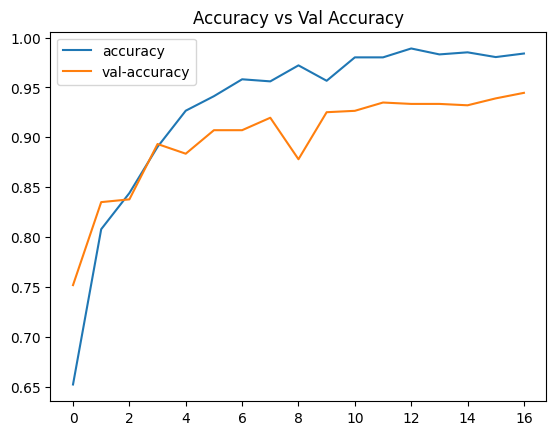

In [32]:
#Plot the graphical interpretation
h = hist.history
plt.plot(h['accuracy'], label = 'accuracy')
plt.plot(h['val_accuracy'], label = 'val-accuracy')
plt.title('Accuracy vs Val Accuracy')
plt.legend()
plt.show()

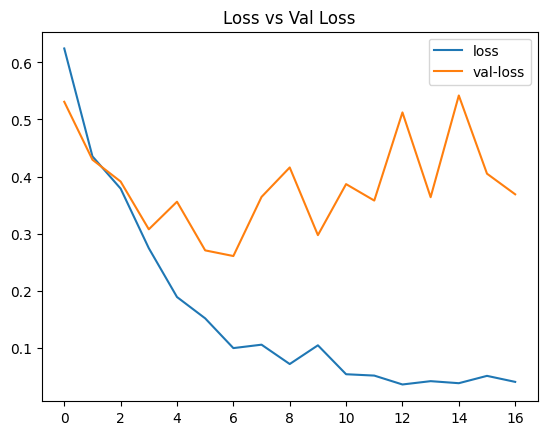

In [33]:
#Plot the graphical interpretation
h = hist.history
plt.plot(h['loss'], label = 'loss')
plt.plot(h['val_loss'], label = 'val-loss')
plt.title('Loss vs Val Loss')
plt.legend()
plt.show()

In [35]:
#Test our model on the test set
from keras.models import load_model
model = load_model('bestmodel.h5')
acc = model.evaluate(X_test, y_test)[1]
print(f'The accuracy of our model is {acc}')

23/23 [==============================] - 22s 884ms/step - loss: 0.3368 - accuracy: 0.9459
The accuracy of our model is 0.9459084868431091


In [37]:
#Try our model on a random image that it has never seen before
#Choose a MRI image with tumor
path = "aug_data/yes/aug_Y112_0_3338.jpg"
img_yes = load_img(path, target_size=(240,240))
img_array_yes = img_to_array(img_yes)/255
img_array_yes = np.expand_dims(img_array_yes, axis=0)
prediction1 = model.predict(img_array_yes)
class1 = np.round(prediction1).astype(int)
if class1 == 0:
  print("The MRI image doesn't have a Tumor")
else:
  print("The MRI image has a tumor")

1/1 [==============================] - 1s 1s/step
The MRI image has a tumor


In [40]:
#Try our model on a random image that it has never seen before
#Choose a MRI image without tumor
path = "aug_data/no/aug_no.jpg"
img_no = load_img(path, target_size=(240,240))
img_array_no = img_to_array(img_no)/255
img_array_no = np.expand_dims(img_array_no, axis=0)
prediction2 = model.predict(img_array_no)[0][0]
class2 = np.round(prediction2).astype(int)
if class2 == 0:
  print("The MRI image doesn't have a Tumor")
else:
  print("The MRI image has a tumor")

1/1 [==============================] - 0s 109ms/step
The MRI image doesn't have a Tumor


Transfer Learning

In [41]:
#Import MobileNet Model
from keras.applications.mobilenet import MobileNet
base_model = MobileNet(input_shape=(240,240,3), include_top=False)

17225924/17225924 [==============================] - 3s 0us/step


In [42]:
#Make the layers of the model untrainable
for layer in base_model.layers:
  layer.trainable = False

In [43]:
#Add a flatten and dense layers to the base model
X = Flatten()(base_model.output)
X = Dense(units=1, activation='sigmoid')(X)
transfer_model = Model(base_model.input, X)

In [44]:
transfer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 120, 120, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 120, 120, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 120, 120, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 120, 120, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 120, 120, 32)      128   

 )                                                               
                                                                 
 conv_dw_8_bn (BatchNormali  (None, 15, 15, 512)       2048      
 zation)                                                         
                                                                 
 conv_dw_8_relu (ReLU)       (None, 15, 15, 512)       0         
                                                                 
 conv_pw_8 (Conv2D)          (None, 15, 15, 512)       262144    
                                                                 
 conv_pw_8_bn (BatchNormali  (None, 15, 15, 512)       2048      
 zation)                                                         
                                                                 
 conv_pw_8_relu (ReLU)       (None, 15, 15, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D  (None, 15, 15, 512)       4608      
 )        

In [45]:
#Compile the new model
transfer_model.compile(optimizer='rmsprop', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

In [46]:
#Early stopping and model checkpoint
est = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.01, patience = 5, verbose = 1, mode = 'auto')
mct = ModelCheckpoint(monitor ='val_accuracy', filepath = './besttransfermodel.h5', verbose = 1, save_best_only = True, mode = 'auto')

cdt = [est, mct]

In [47]:
#Fit our new model
transfer_hist = transfer_model.fit(x = X_train, y = y_train, batch_size = 32, epochs = 30, validation_data = (X_val, y_val), callbacks = cdt, verbose = 1)

Epoch 1/30
106/106 [==============================] - ETA: 0s - loss: 1.5193 - accuracy: 0.8824
Epoch 1: val_accuracy improved from -inf to 0.97642, saving model to .\besttransfermodel.h5
106/106 [==============================] - 238s 2s/step - loss: 1.5193 - accuracy: 0.8824 - val_loss: 0.1077 - val_accuracy: 0.9764
Epoch 2/30
106/106 [==============================] - ETA: 0s - loss: 0.4964 - accuracy: 0.9602
Epoch 2: val_accuracy improved from 0.97642 to 0.98613, saving model to .\besttransfermodel.h5
106/106 [==============================] - 189s 2s/step - loss: 0.4964 - accuracy: 0.9602 - val_loss: 0.0913 - val_accuracy: 0.9861
Epoch 3/30
106/106 [==============================] - ETA: 0s - loss: 0.1480 - accuracy: 0.9899
Epoch 3: val_accuracy improved from 0.98613 to 0.99029, saving model to .\besttransfermodel.h5
106/106 [==============================] - 161s 2s/step - loss: 0.1480 - accuracy: 0.9899 - val_loss: 0.0471 - val_accuracy: 0.9903
Epoch 4/30
106/106 [==============

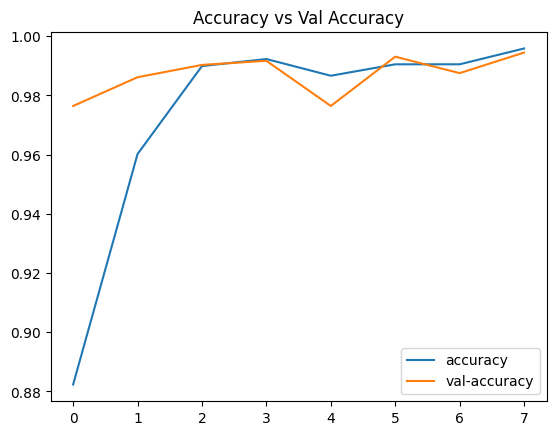

In [48]:
#Plot the graphical interpretation
h = transfer_hist.history
plt.plot(h['accuracy'], label = 'accuracy')
plt.plot(h['val_accuracy'], label = 'val-accuracy')
plt.title('Accuracy vs Val Accuracy')
plt.legend()
plt.show()

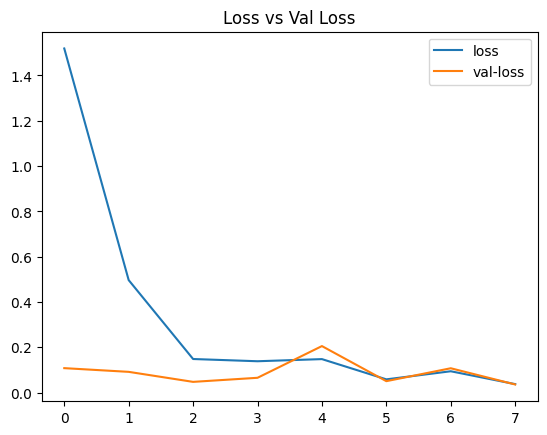

In [49]:
#Plot the graphical interpretation
h = transfer_hist.history
plt.plot(h['loss'], label = 'loss')
plt.plot(h['val_loss'], label = 'val-loss')
plt.title('Loss vs Val Loss')
plt.legend()
plt.show()

In [51]:
#Test our model on the test set
from keras.models import load_model
model = load_model('besttransfermodel.h5')
acc = model.evaluate(X_test, y_test)[1]
print(f'The accuracy of our model is {acc}')

23/23 [==============================] - 31s 1s/step - loss: 0.0261 - accuracy: 0.9958
The accuracy of our model is 0.9958391189575195
